# Visualizing Networks

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Take in csv(daily edges) and remove empty node 

In [2]:
# replace NaN with emptynodes for every csv
def replacenan(df):
    dfnew = df.replace(np.nan, 'emptynode', regex=True)
    return dfnew

In [3]:
#read in csv and turn it into df and calculate the node weight
def csv_df(csv):
    df = replacenan(pd.read_csv(csv))
    dout=df.groupby(['source']).sum()
    dout=dout.rename(columns={'source':'Address','amount':'Amount_out'})
    din=df.groupby(['target']).sum()
    din=din.rename(columns={'target':'Address','amount':'Amount_in'})
    combo=din.join(dout, how='outer')
    combo['Amount_in']=combo['Amount_in'].fillna(0)
    combo['Amount_out']=combo['Amount_out'].fillna(0)
    combo['Total']=combo.Amount_in+combo.Amount_out
    return combo,df

In [4]:
combo,df = csv_df('15.csv')

### attach position to nodes

In [5]:
position = pd.read_csv('nodes with coordinates.csv')

In [6]:
pos_list = position.reset_index()[['longitude', 'latitude']].values.tolist()

In [7]:
pos_list = [np.asarray(sublist) for sublist in pos_list]

In [8]:
pos_list[0:5]

[array([-27.44883347, 896.9679565 ]),
 array([266.1700745, 682.5604858]),
 array([386.9801636 ,  84.14353943]),
 array([287.8094177, 442.5010681]),
 array([158.5778198, 903.7891846])]

### Attach weight to the node

In [9]:
def attach_weight(combo):
    weight_list = combo['Total'].values.tolist()
    weight_dict_list = [{'Total': v} for v in weight_list]
    return weight_dict_list

In [10]:
weight_dict_list = attach_weight(combo)

### Draw the graph

In [11]:
# See what layouts are available in networkX
[x for x in nx.__dir__() if x.endswith('_layout')]

['circular_layout',
 'kamada_kawai_layout',
 'random_layout',
 'rescale_layout',
 'shell_layout',
 'spring_layout',
 'spectral_layout',
 'fruchterman_reingold_layout']

In [12]:
#turn the df into graph, attach weight and position attribute to nodes; df = daily transaction record
def df_graph(df, weight_dict_list):   
    Graphtype = nx.Graph()
    G = nx.from_pandas_edgelist(df, edge_attr='amount', create_using=Graphtype)
    G.remove_node('emptynode')
    node_weight = dict(zip(list(G.node), weight_dict_list))
    nx.set_node_attributes(G, node_weight,'Total')
    
    return G
    

In [13]:
G = df_graph(df,weight_dict_list)

In [14]:
# set labels for 5 most popular nodes
sort_node = dict(G.degree(weight = 'amount'))
node_list = sorted((sort_node).values())
hubs = [node for node,weight in sort_node.items() if weight in node_list[95:100]]  

In [15]:
labels = {}   
for node in G.nodes():
    if node in hubs:
        #set the node name as the key and the label as its value 
        labels[node] = node
#set the argument 'with labels' to False so you have unlabeled graph


In [16]:
labels

{'1JDkMUvVKv4x9gq47zjbPwMNLsDbsRCVYr': '1JDkMUvVKv4x9gq47zjbPwMNLsDbsRCVYr',
 '1AHjpLAQGZjiCrtMAxkfGedYVxCUjMY7YY': '1AHjpLAQGZjiCrtMAxkfGedYVxCUjMY7YY',
 '136PqkWb4VbsCDwi8gLTUm6GhuSgJWtPFU': '136PqkWb4VbsCDwi8gLTUm6GhuSgJWtPFU',
 '17A16QmavnUfCW11DAApiJxp7ARnxN5pGX': '17A16QmavnUfCW11DAApiJxp7ARnxN5pGX',
 '12cgpFdJViXbwHbhrA3TuW1EGnL25Zqc3P': '12cgpFdJViXbwHbhrA3TuW1EGnL25Zqc3P'}

(-995.1243622349998,
 1003.1166107350001,
 -1009.0319335072037,
 994.8938238407419)

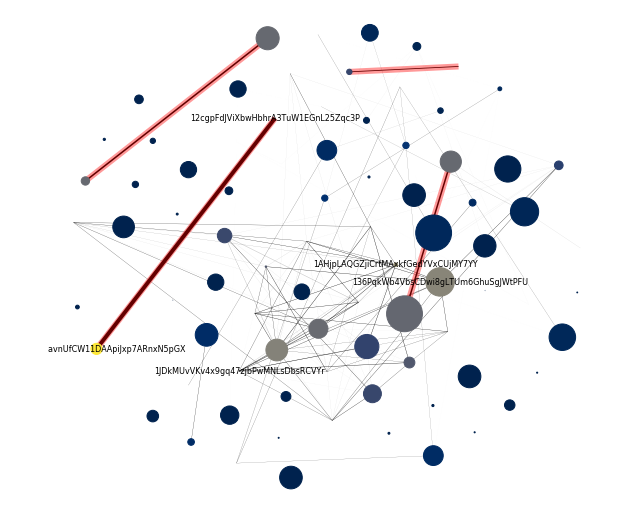

In [17]:
# Draw graph with varying node color, node size, and edge width
%matplotlib inline


plt.figure(figsize=(10,9))

# set node color according to weighted degree
node_color = [G.degree(v, weight ='amount') for v in G]
#set node size according to daily total transaction amount of a node
node_size = [0.5*nx.get_node_attributes(G, 'Total')[v]['Total'] for v in G]
#set edge width according to edge amount
edge_width = [0.0015*G[u][v]['amount'] for u,v in G.edges()]

pos = dict(zip(list(G.node), pos_list))



nx.draw_networkx(G, pos, node_size=node_size, 
                 node_color=node_color, with_labels=False, 
                 width=edge_width, cmap=plt.cm.cividis)
# Draw specific edges and add labels to specific nodes
greater_than_1 = [x for x in G.edges(data=True) if x[2]['amount']>500]
nx.draw_networkx_edges(G, pos, edgelist=greater_than_1, edge_color='r', alpha=0.4, width=6)

nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='k')
plt.axis('off')